In [74]:
from pennylane import qchem
import pennylane as qml

from pennylane import numpy as np
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator
from openfermion.ops import QubitOperator


from groupedFermionicOperator import groupedFermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.chemistry import FermionicOperator

In [75]:
def qiskit_to_pennylane_converter(qwpo):
    p_list = qwpo.paulis
    coeff_list = []
    obslist = []
    for i in range(len(p_list)):
        coeff_list.append(p_list[i][0])
        s = p_list[i][1].to_label()
        j = 0
        for w in s: 
            if (w == "X"):
                qobs1 = qml.PauliX(j)
            if (w == "Y"):
                qobs1 = qml.PauliY(j)
            if (w == "Z"):
                qobs1 = qml.PauliZ(j)
            if (w == "I"):
                qobs1 = qml.Identity(j)
            if (j > 0):
                qobs = qobs @ qobs1
            else:
                qobs = qobs1
            j += 1
        obslist.append(qobs)
    return qml.Hamiltonian(coeff_list, obslist)

In [76]:
symbols = ["H", "H", "H"]
x = np.array([0.028, 0.054, 0.0, 0.886, 1.610, 0.0, 1.855, 0.002, 0.0], requires_grad=True)

def Ha(x):
    #cord = np.array([0.0, 0.0, 0.0,x[0],0, 0.0, x[1],x[2], 0], dtype=np.float64) # in Bohr
    cord = x
    driver = PySCFDriver(atom=f"H {cord[0]} {cord[1]} {cord[2]}; H {cord[3]} {cord[4]} {cord[5]}; H {cord[6]} {cord[7]} {cord[8]}", unit=UnitsType.BOHR, 
                         charge=1, spin=0, basis='sto-3g')
    
    molecule = driver.run()
    shift = molecule.nuclear_repulsion_energy
    num_electrons = molecule.num_alpha+molecule.num_beta
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    g = groupedFermionicOperator(ferOp, num_electrons,mode="rhf")
    qubitOp = g.to_paulis()
    ddd = {'paulis': [{"coeff": {"imag": 0.00, "real": shift }, "label": "IIII" }]}
    b = WeightedPauliOperator.from_dict(ddd)
    qubitOp.add(b)
    H = qiskit_to_pennylane_converter(qubitOp)
    return H

In [77]:
num_wires = len(Ha(x).wires)
dev = qml.device("default.qubit", wires=num_wires)


def layer(W):
    for i in range(num_wires):
    #    qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
        qml.RY(W[i,0],wires=i)
    qml.broadcast(qml.CNOT, wires=range(num_wires), pattern="chain")

@qml.qnode(dev)
def circuit(params, obs):
    for W in params:
        layer(W)
    return qml.expval(obs)

def cost(params, x):
    hamiltonian = Ha(x)
    return circuit(params, obs=hamiltonian)#+shift

def grad_x(params, x):
    grad_h = qml.finite_diff(Ha)(x)
    grad = [circuit(params, obs=obs) for obs in grad_h]
    return np.array(grad)

opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

In [78]:
num_layers = 2
params = 0.1*np.random.randn(num_layers, num_wires, 1, requires_grad=True)

In [79]:
from functools import partial

# store the values of the cost function
energy = []

# store the values of the bond length
bond_length = []

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

for n in range(100):

    # Optimize the circuit parameters
    params.requires_grad = True
    x.requires_grad = False
    params, _ = opt_theta.step(cost, params, x)

    # Optimize the nuclear coordinates
    x.requires_grad = True
    
    params.requires_grad = False

    _, x = opt_x.step(cost, params, x, grad_fn=grad_x)

    energy.append(cost(params, x))
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)

    if n % 2 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha,  bond length = {bond_length[-1]:.5f} A")
        #print (f"Step = {n},  E = {energy[-1]:.8f} Ha")
        #print(f"x: {x}")
        #print(f"para: {params}")
    # Check maximum component of the nuclear gradient
    if np.max(grad_x(params, x)) <= 1e-05:
        print("******END*****")
        break

Step = 0,  E = -1.25137650 Ha,  bond length = 0.94663 A
Step = 2,  E = -1.26845003 Ha,  bond length = 0.95760 A
Step = 4,  E = -1.27268342 Ha,  bond length = 0.96672 A
Step = 6,  E = -1.27385865 Ha,  bond length = 0.97337 A
Step = 8,  E = -1.27422274 Ha,  bond length = 0.97783 A
Step = 10,  E = -1.27434742 Ha,  bond length = 0.98070 A
Step = 12,  E = -1.27439458 Ha,  bond length = 0.98250 A
Step = 14,  E = -1.27441432 Ha,  bond length = 0.98362 A
Step = 16,  E = -1.27442340 Ha,  bond length = 0.98431 A
Step = 18,  E = -1.27442796 Ha,  bond length = 0.98476 A
Step = 20,  E = -1.27443041 Ha,  bond length = 0.98505 A
Step = 22,  E = -1.27443180 Ha,  bond length = 0.98523 A
Step = 24,  E = -1.27443264 Ha,  bond length = 0.98536 A
Step = 26,  E = -1.27443317 Ha,  bond length = 0.98545 A
Step = 28,  E = -1.27443353 Ha,  bond length = 0.98550 A
Step = 30,  E = -1.27443379 Ha,  bond length = 0.98555 A
Step = 32,  E = -1.27443399 Ha,  bond length = 0.98558 A
Step = 34,  E = -1.27443416 Ha,  bon

In [80]:
print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")


Final value of the ground-state energy = -1.27443416 Ha

Ground-state equilibrium geometry
symbol    x        y        z
  H    -0.0064   0.0147   0.0000
  H    0.9194   1.6308   0.0000
  H    1.8562   0.0208   0.0000


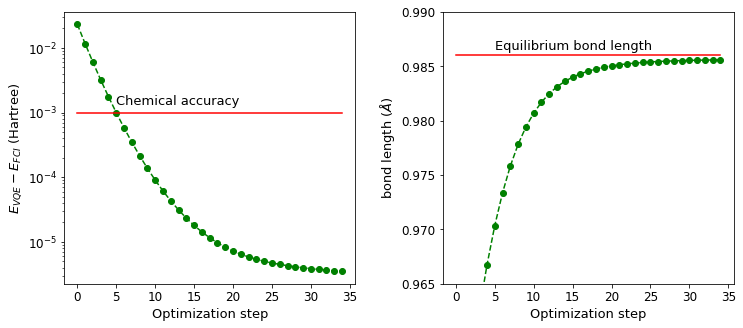

In [81]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
E_fci = -1.27443765658
E_vqe = np.array(energy)
ax1 = fig.add_subplot(121)
ax1.plot(range(n+1), E_vqe-E_fci, 'go-', ls='dashed')
ax1.plot(range(n+1), np.full(n+1, 0.001), color='red')
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("$E_{VQE} - E_{FCI}$ (Hartree)", fontsize=13)
ax1.text(5, 0.0013, r'Chemical accuracy', fontsize=13)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add bond length plot on column 2
d_fci = 0.986
ax2 = fig.add_subplot(122)
ax2.plot(range(n+1), bond_length, 'go-', ls='dashed')
ax2.plot(range(n+1), np.full(n+1, d_fci), color='red')
ax2.set_ylim([0.965,0.99])
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("bond length ($\AA$)", fontsize=13)
ax2.text(5, 0.9865, r'Equilibrium bond length', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3)
plt.show()
